# Problem Statement

Company and investors are not able to identify the applicants profile properly before loan approval and hence they are facing both business and financial loss.

# Objective

The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.

## Data Sourcing

Campany already given the dataset contains the information about past loan applicants and whether they ‘defaulted’ or not.

For this case study we need to focus only on provided dataset given by company.

### Import libraries

In [410]:
import pandas as pd
import seaborn as sns;
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno

### Read and store the dataset

In [411]:
# loan_ds stands for loan dataset
path_to_dataset = '/kaggle/input/lendingclub/loan.csv'
loan_ds = pd.read_csv(path_to_dataset, header=0, low_memory=False)

In [412]:
# Shape of loan dataset
rows = loan_ds.shape[0]
columns = loan_ds.shape[1]
print('Total number of Rows : ', rows)
print('Total number of Columns : ', columns)

Total number of Rows :  39717
Total number of Columns :  111


In [413]:
# setting to display all rows & columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Data Cleaning

Lets clean the data before doing the analysis

### Fixing Rows and Columns

Using this matrix we can very quickly find the pattern of missingness in the dataset

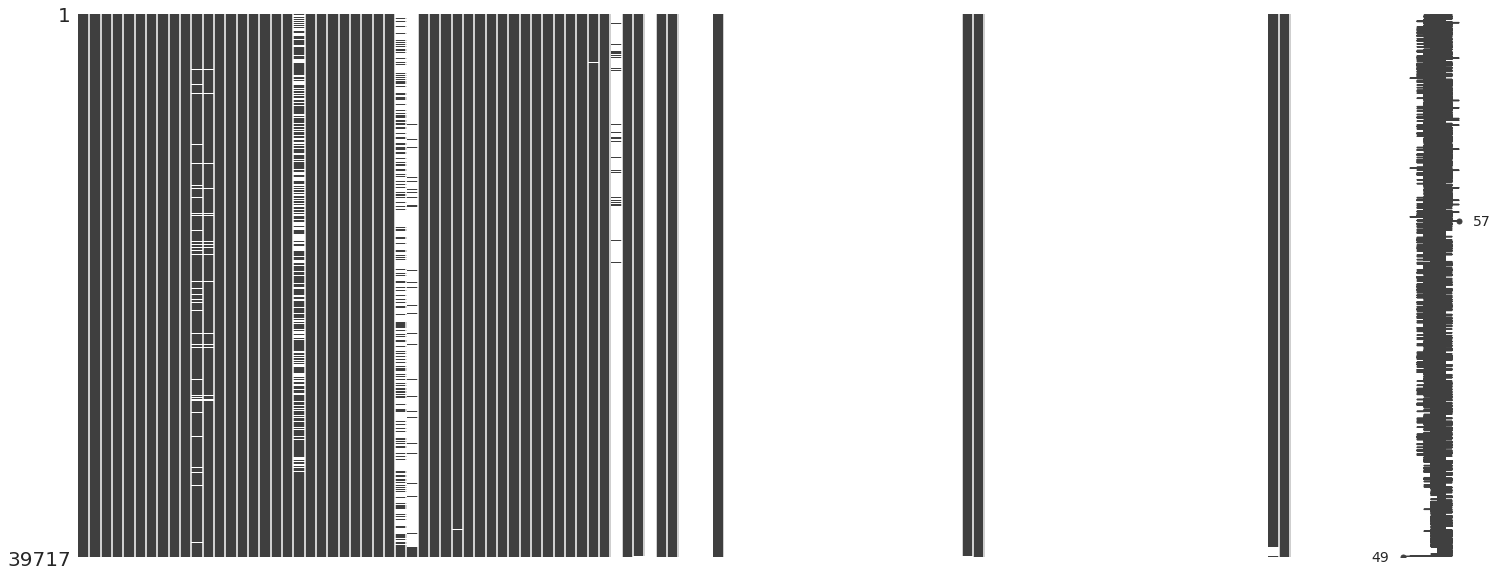

In [414]:
msno.matrix(loan_ds)
plt.show()

### Insights:

By looking at the above plot, we can conclude, There are many columns have white spaces.
1. Columns having mix of black and white lines: This shows these columns contains some missing values.
2. Columns having only white line: This shows all the values are missing.
3. Columns having only black values: This shows none of the values are missing.

Checking null values

In [415]:
(loan_ds.isnull().mean()*100).sort_values(ascending=False)

verification_status_joint         100.000000
annual_inc_joint                  100.000000
mo_sin_old_rev_tl_op              100.000000
mo_sin_old_il_acct                100.000000
bc_util                           100.000000
bc_open_to_buy                    100.000000
avg_cur_bal                       100.000000
acc_open_past_24mths              100.000000
inq_last_12m                      100.000000
total_cu_tl                       100.000000
inq_fi                            100.000000
total_rev_hi_lim                  100.000000
all_util                          100.000000
max_bal_bc                        100.000000
open_rv_24m                       100.000000
open_rv_12m                       100.000000
il_util                           100.000000
total_bal_il                      100.000000
mths_since_rcnt_il                100.000000
open_il_24m                       100.000000
open_il_12m                       100.000000
open_il_6m                        100.000000
open_acc_6

### Insights:

1. From column **verification_status_joint** to **mths_since_last_major_derog** : Percentage of null values is **100%** in these columns. i.e. These columns having only null values. We can get rid of these columns as there is nothing to analyse.
2. Column **mths_since_last_record** and **mths_since_last_delinq** : Percentage of null values is greater than **60%** in these columns which is very large. This will only disturb the analysis, we can get rid of these columns.

Remove columns from the dataset having more than **60%** null values

In [416]:
loan_ds_1 = loan_ds.loc[:, loan_ds.isnull().mean() < 0.60]

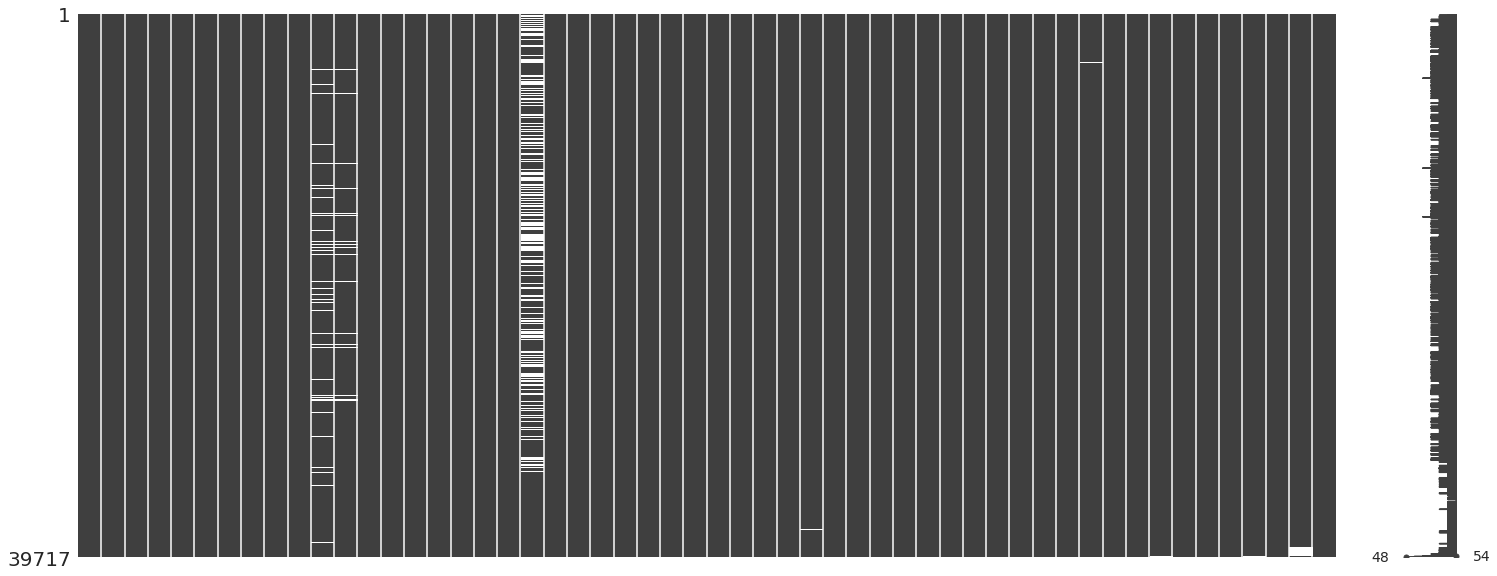

In [417]:
msno.matrix(loan_ds_1)
plt.show()

### Insights:

Shows lesser white spaces. Since most of the columns have been removed from dataset where null values were greater than 60%

By looking at the head and tail seems like many columns contains lot of zeroes. Please check **loan_ds_1.head(40)** and **loan_ds_1.tail(40)**

Checking for zero values.

In [418]:
loan_ds_1.isin([0, 0.0]).mean().sort_values(ascending=False)

delinq_amnt                   1.000000
acc_now_delinq                1.000000
tax_liens                     0.999018
chargeoff_within_12_mths      0.998590
collections_12_mths_ex_med    0.998590
out_prncp_inv                 0.971297
out_prncp                     0.971297
total_rec_late_fee            0.948486
pub_rec                       0.946723
pub_rec_bankruptcies          0.940126
collection_recovery_fee       0.904776
recoveries                    0.893799
delinq_2yrs                   0.891432
inq_last_6mths                0.485938
revol_bal                     0.025027
dti                           0.004608
total_pymnt_inv               0.004154
funded_amnt_inv               0.003248
last_pymnt_amnt               0.001863
total_rec_prncp               0.001863
total_rec_int                 0.001788
total_pymnt                   0.000403
int_rate                      0.000000
last_credit_pull_d            0.000000
emp_title                     0.000000
policy_code              

### Insights:
1. From column **delinq_amnt** to **delinq_2yrs** : Percentage of zero is greater than **89%** for these columns. i.e. These columns having mostly zero values. We can get rid of these columns as there is nothing to analyse.

Remove columns from the dataset having more than **89%** zero values

In [419]:
loan_ds_2 = loan_ds_1.loc[:, loan_ds_1.isin([0, 0.0]).mean() < 0.89]

In [420]:
loan_ds_2.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'policy_code', 'application_type'],
      dtype='object')

### Lets identify the important variables to find the key factors behind the defulters

There are broadly three types of variables:

1. Those which are related to the applicant. e.g. member_id, emp_title, emp_length, home_ownership, annual_inc, zip_code, addr_state, dti. 
    
2. Those which are related to Loan characteristics e.g. id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, grade, sub_grade, verification_status, loan_status, url, desc, purpose, title, initial_list_status, policy_code, application_type. 

3. Those which are related to customer behavior **(variables generated after the loan is approved)** e.g. installment, issue_d, pymnt_plan, earliest_cr_line, inq_last_6mths, open_acc, revol_bal, revol_util, total_acc, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d.

#### Selected variable

1. **emp_length**: Employment length could be directly relates to financial status of the borrower.
2. **home_ownership**: Home ownership could be directly relates to financial status of the borrower e.g. If borrower is already owning house or morgage or on rent.
3. **annual_inc**: Annual Income.
4. **addr_state**: Just kept it to analyse the state wise loan status.
5. **dti**: Debt to income ratio could play important role to identify defaulters.
6. **loan_amnt**: Loan Amount
7. **funded_amnt**: Funded Amount by Company
8. **funded_amnt_inv**: Funded Amount by Investors
9. **term**: Terms of loan
10. **int_rate**: Interest Rate
11. **grade**: Grades
12. **sub_grade**: Sub Grades
13. **verification_status**: Loan verification status
14. **loan_status**: Indicating defaulters. Possible values Charged Off (Defaulter), Fully Paid, Current
15. **purpose**: Purpose of loan


#### Ignored variables

1. **member_id**: borrowers id
2. **emp_title**: Job title supplied by borrower
3. **zip_code**: zip code. Not looking meaning full
4. **id**: Loan id
5. **url**: url of loan page with data
6. **desc**: Loan description provided by borrower
7. **title**: Loan title filled by borrower while apply for loan
8. **initial_list_status**: Having single value equals to **f**
9. **policy_code**: Having single value equals to **1**
10. **application_type**: Having single value equals to **INDIVISUAL**

and **variables related to customer behavior i.e. variables generated after the loan is approved**. customer behavior variables are not available at the time of loan application, and thus they cannot be used as predictors for credit approval

In [421]:
loan_ds_3 = loan_ds_2[['emp_length', 'home_ownership', 'annual_inc', 'addr_state', 'dti', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'grade', 'sub_grade', 'verification_status', 'loan_status', 'purpose']]

In [422]:
loan_ds_3.head(1)

,emp_length,home_ownership,annual_inc,addr_state,dti,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,grade,sub_grade,verification_status,loan_status,purpose
0,10+ years,RENT,24000.0,AZ,27.65,5000,5000,4975.0,36 months,10.65%,B,B2,Verified,Fully Paid,credit_card


Lets strip the % sign from interest rate column and convert to float

In [423]:
loan_ds_3['int_rate'] = loan_ds_3.int_rate.apply(lambda x: float(x[0:-1]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [424]:
loan_ds_3.home_ownership.value_counts()

RENT        18899
MORTGAGE    17659
OWN          3058
OTHER          98
NONE            3
Name: home_ownership, dtype: int64

As per data dictonary possible values for home_ownership are RENT, OWN, MORTGAGE and OTHER. But in data set NONE is also present. Hence moving NONE to OTHER

In [425]:
loan_ds_3.home_ownership = loan_ds_3.home_ownership.apply(lambda x: 'OTHER' if x == 'NONE' else x)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [426]:
loan_ds_3.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

Loan status marked **Current** are neither **Fully Paid** nor **Charged Off(defaulted)**, So we can get rid of rows having loan status as **Current**.

In [427]:
loan_ds_4 = loan_ds_3[-(loan_ds_3.loan_status == 'Current')]

Tagging the other two values (Fully Paid and Charged Off) as 0 or 1 to make your analysis simple and clean

In [428]:
loan_ds_4.loan_status = loan_ds_4.loan_status.apply(lambda x: 1 if x == 'Charged Off' else 0)

In [429]:
loan_ds_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   emp_length           37544 non-null  object 
 1   home_ownership       38577 non-null  object 
 2   annual_inc           38577 non-null  float64
 3   addr_state           38577 non-null  object 
 4   dti                  38577 non-null  float64
 5   loan_amnt            38577 non-null  int64  
 6   funded_amnt          38577 non-null  int64  
 7   funded_amnt_inv      38577 non-null  float64
 8   term                 38577 non-null  object 
 9   int_rate             38577 non-null  float64
 10  grade                38577 non-null  object 
 11  sub_grade            38577 non-null  object 
 12  verification_status  38577 non-null  object 
 13  loan_status          38577 non-null  int64  
 14  purpose              38577 non-null  object 
dtypes: float64(4), int64(3), object(8)
m

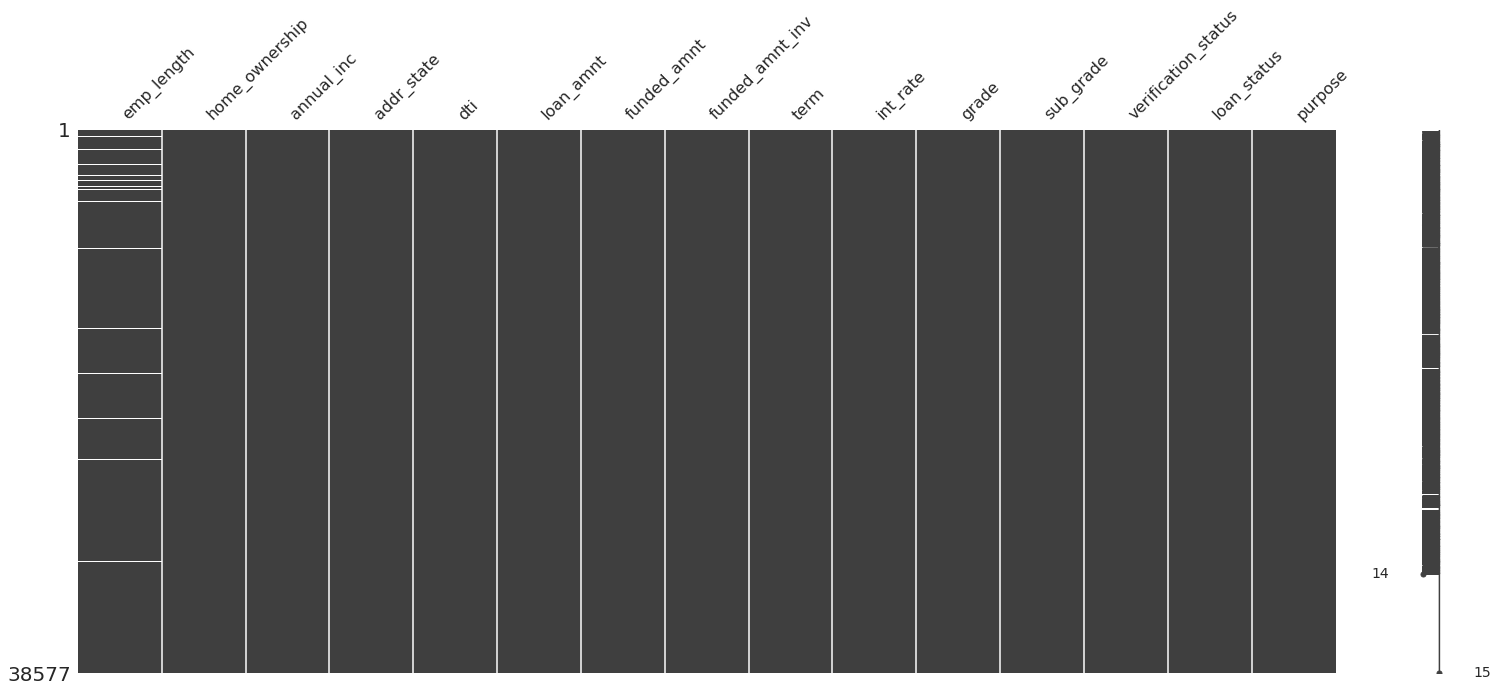

In [430]:
msno.matrix(loan_ds_4)
plt.show()

### Insights:

Employment length is still having null values. Lets remove rowws with null values.

In [431]:
loan_ds_5 = loan_ds_4[-loan_ds_4.emp_length.isnull()]

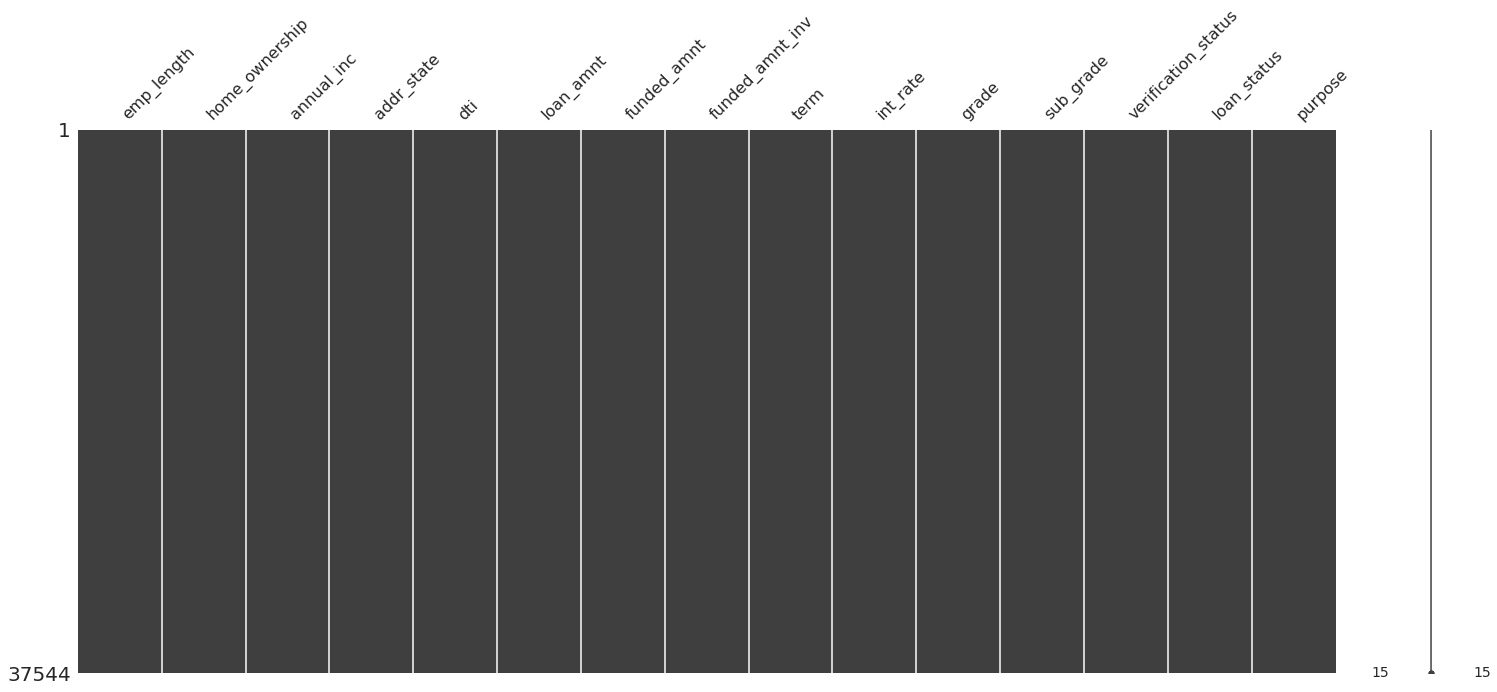

In [432]:
msno.matrix(loan_ds_5)
plt.show()

### Insight:

Dataset is ready for the analysis.

----

## Exploratory Data Analysis

### Unordered Categorical Variable - Univariate Analysis
Important Unordered categorical variable present in dataset are 
1. home_ownership
2. verification_status
3. loan_status
4. purpose
5. addr_state

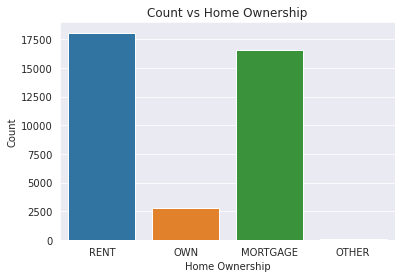

In [433]:
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_5, x='home_ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.title('Count vs Home Ownership')
plt.show()

### Insights:
There are many people belong to mortgage category. That mean they already borrowed the money from some other sources. That may by burden them and in turn they will become defaulter.

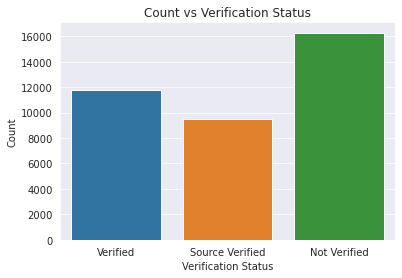

In [434]:
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_5, x='verification_status')
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.title('Count vs Verification Status')
plt.show()

### Insights:

More than 16000 loans are not verified. Thats may be cause of defaulters.

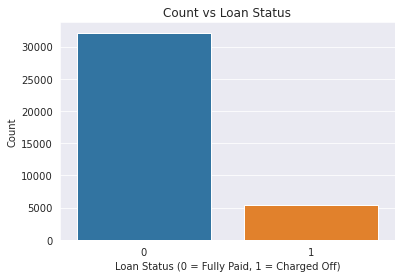

In [435]:
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_5, x='loan_status')
plt.xlabel('Loan Status (0 = Fully Paid, 1 = Charged Off)')
plt.ylabel('Count')
plt.title('Count vs Loan Status')
plt.show()

### Insights:
More than 5000 loans have Charged Off out of approximately 37000.

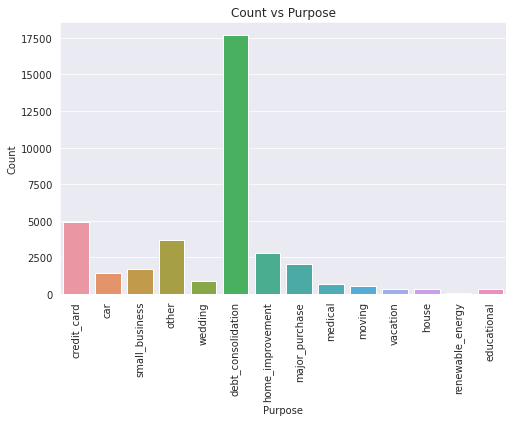

In [436]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_5, x='purpose')
plt.xlabel('Purpose')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Count vs Purpose')
plt.show()

### Insights:

People are taking loan mostly to do debt consolidation followed by credit card, home improvement and major purchase.

**Debt Consolidation**: Debt consolidation means that your various debts–whether credit card bills or other loan payments–are rolled into one loan or monthly payment. If you have multiple credit card accounts or loans, consolidation may be a way to simplify or lower payments.

Question:
1. What is Major Purchase?
2. What is other (do remember other is the third most purpose)?

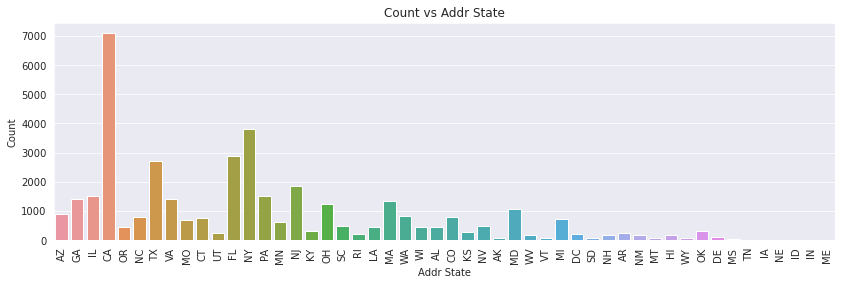

In [437]:
plt.figure(figsize=(14, 4))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_2, x='addr_state')
plt.xlabel('Addr State')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Count vs Addr State')
plt.show()

### Insights:

1. People from state with code CA, NY, FL, TX and NJ are the top 5 for having loans. It may be possible most defaulters belongs to these states. Company should be causius while giving loans in the state. Assuming more loans more defaulters.
2. People from state with code UT, RI, AK, VT, SD etc are less intrested in having loans.

### Ordered Categorical Variables - Univariate Analysis

Ordered categorical variables prsent in data set are:
1. emp_length
2. term
3. grade
4. sub_grade

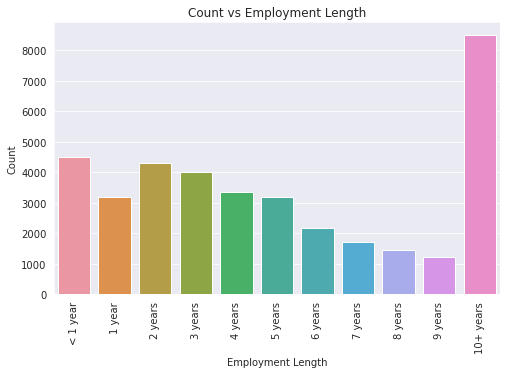

In [438]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_5, x='emp_length', order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'])
plt.xlabel('Employment Length')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Count vs Employment Length')
plt.show()

### Insights:

1. Most people taking loan having employment length more than 10 Years or less than 1 year.
2. As the Employment length increases count of loan decreases till 9 years and suddenly increses in 10+ years.

It may be possible most defaulters belongs to group having employment length less than 1 year or more than 10 years. Company should be causius while giving loans to such group. Assuming more loans more defaulters.

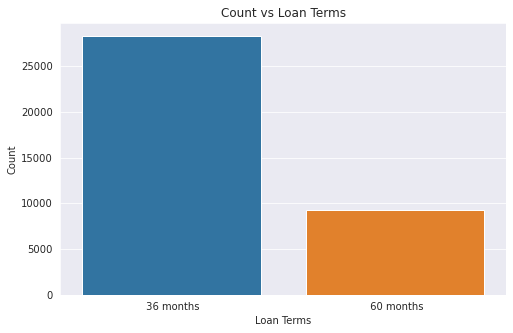

In [439]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_5, x='term')
plt.xlabel('Loan Terms')
plt.ylabel('Count')
plt.title('Count vs Loan Terms')
plt.show()

### Insights:

More than 25K loan are having terms of 36 months. There is possibility of lesser terms, higher emi and higher interest rate. In result, cause people to become defaulter.

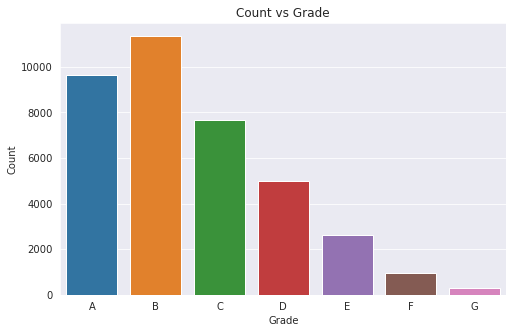

In [440]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_5, x='grade', order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title('Count vs Grade')
plt.show()

### Insights:

1. Most people avails loan at lower interest rates having grade A, B and C.
2. Loans with grades D, E, F and G are higher interest rate loans. Hence the loan count is lesser.

Reference for understanding grade for Lending Club:
https://www.lendingclub.com/foliofn/rateDetail.action

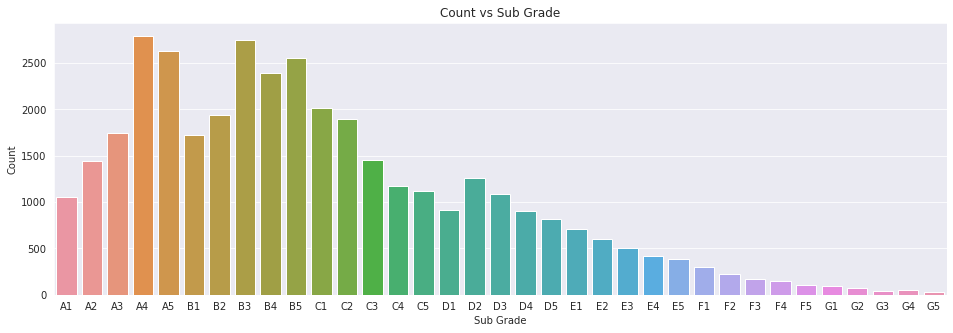

In [441]:
plt.figure(figsize=(16, 5))
sns.set_style("darkgrid")
sns.countplot(data=loan_ds_5, x='sub_grade', order=['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2',
       'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4',
       'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5'])
plt.xlabel('Sub Grade')
plt.ylabel('Count')
plt.title('Count vs Sub Grade')
plt.show()

### Insights:

1. Most people avails loan at lower interest rates having grade A1-A5, B1-B5 and C1-C5.
2. Loans with grades D(1-5), E(1-5), F(1-5) and G(1-5) are higher interest rate loans. Hence the loan count is lesser.

Reference for understanding grade for Lending Club:
https://www.lendingclub.com/foliofn/rateDetail.action

In [442]:
loan_ds_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37544 entries, 0 to 39716
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   emp_length           37544 non-null  object 
 1   home_ownership       37544 non-null  object 
 2   annual_inc           37544 non-null  float64
 3   addr_state           37544 non-null  object 
 4   dti                  37544 non-null  float64
 5   loan_amnt            37544 non-null  int64  
 6   funded_amnt          37544 non-null  int64  
 7   funded_amnt_inv      37544 non-null  float64
 8   term                 37544 non-null  object 
 9   int_rate             37544 non-null  float64
 10  grade                37544 non-null  object 
 11  sub_grade            37544 non-null  object 
 12  verification_status  37544 non-null  object 
 13  loan_status          37544 non-null  int64  
 14  purpose              37544 non-null  object 
dtypes: float64(4), int64(3), object(8)
m

### Quantitative Variables - Univariate Analysis

Quantitive variable are:
1. annual_inc
2. dti
3. loan_amnt
4. funded_amnt_inv
5. int_rate

In [443]:
loan_ds_5.annual_inc.describe()

count    3.754400e+04
mean     6.940708e+04
std      6.467698e+04
min      4.000000e+03
25%      4.100000e+04
50%      6.000000e+04
75%      8.300000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

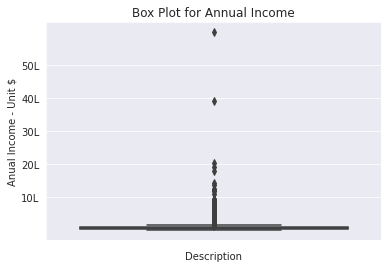

In [444]:
sns.boxplot(data=loan_ds_5, y='annual_inc')
ticks = np.arange(1000000, 6000000, 1000000)
labels = ["{}L".format(i//100000) for i in ticks]
plt.yticks(ticks, labels)
plt.xlabel('Description')
plt.ylabel('Anual Income - Unit $')
plt.title('Box Plot for Annual Income')
plt.show()

### Insights:

Too many ouliears present in the data set for annual income. Lets include only 90th percentile of annual income.

**Assuming borrowers with very high annual income can not be defaulters**

In [445]:
loan_ds_6 = loan_ds_5[(loan_ds_5.annual_inc < loan_ds_5.annual_inc.quantile(0.90))]

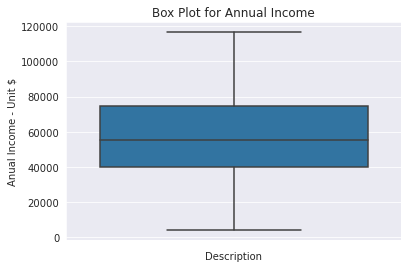

In [446]:
sns.boxplot(data=loan_ds_6, y='annual_inc')
plt.xlabel('Description')
plt.ylabel('Anual Income - Unit $')
plt.title('Box Plot for Annual Income')
plt.show()

In [447]:
loan_ds_6.annual_inc.describe()

count     33789.000000
mean      57795.435199
std       23616.482851
min        4000.000000
25%       40000.000000
50%       55000.000000
75%       74800.000000
max      116664.000000
Name: annual_inc, dtype: float64

In [448]:
loan_ds_6.shape

(33789, 15)

From the shape, Its clear, few rows with very high annual income have been removed from loan dataset 6 (loan_ds_6)

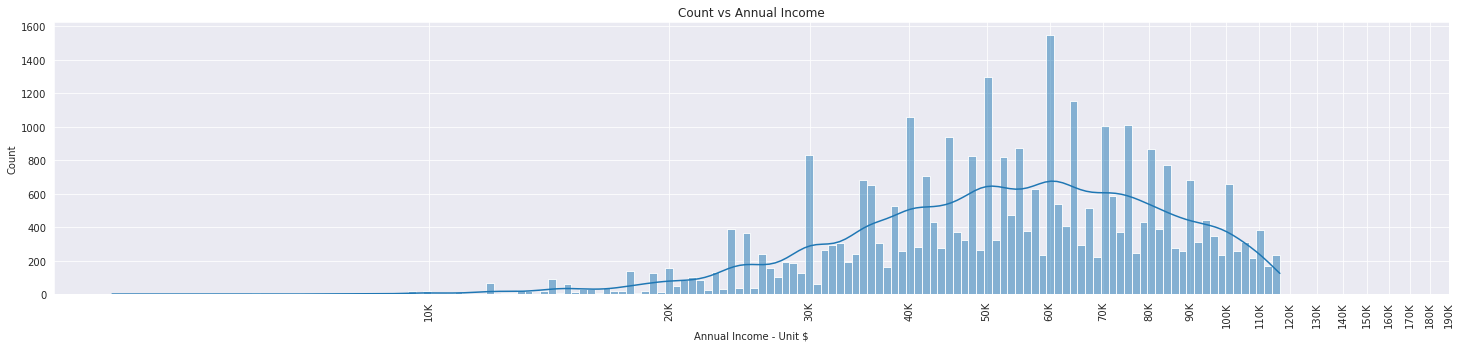

In [449]:
plt.figure(figsize=(25, 5))
plot_annual_inc = sns.histplot(data=loan_ds_6, x='annual_inc', log_scale=True, kde=True, bins=150)
ticks = np.arange(10000, 200000, 10000)
labels = ["{}K".format(i//1000) for i in ticks]
plt.xticks(ticks, labels, rotation=90)
plt.xlabel('Annual Income - Unit $')
plt.ylabel('Count')
plt.title('Count vs Annual Income')
plt.show()

### Insights:

1. People have annual income below 120K.
2. We can see spike in the figure for 15K, 20K, 25K, 30K, 40K, 50K etc. i.e. Many people are having annual income in multiples of five.
3. Most people are having annual income between 40K and 80K.
4. Maximum number of people are having annual income arround 60K.

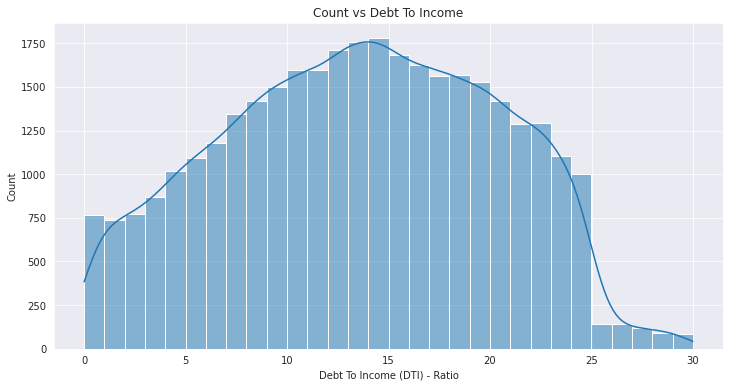

In [450]:
plt.figure(figsize=(12, 6))
plot_annual_inc = sns.histplot(data=loan_ds_6, x='dti', kde=True, bins=30)
plt.xlabel('Debt To Income (DTI) - Ratio')
plt.ylabel('Count')
plt.title('Count vs Debt To Income')
plt.show()

### Insights:

1. Number of loan is increasing till 15 afterwords it started decreasing and I can see a sudden fall around 25.
2. Count of loan is very less when dti is greater than 25. i.e. very few loans are approved when dti is greater than 25.
3. Probability of defaulters increses when dti increases beyond 25.

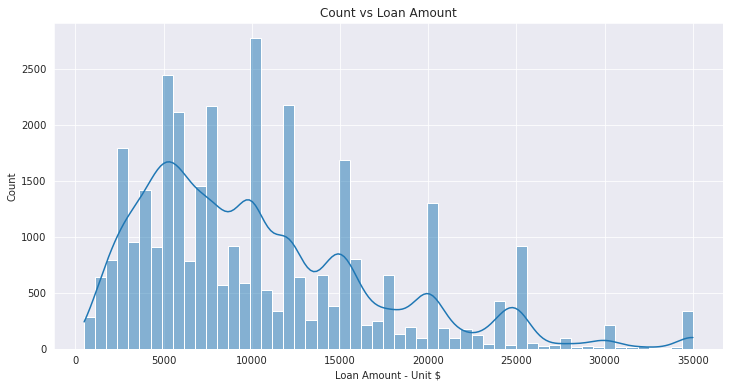

In [451]:
plt.figure(figsize=(12, 6))
plot_annual_inc = sns.histplot(data=loan_ds_6, x='loan_amnt', kde=True, bins=55)
plt.xlabel('Loan Amount - Unit $')
plt.ylabel('Count')
plt.title('Count vs Loan Amount')
plt.show()

### Insights:

1. Count of loan is maximum for 10K loan amount.
2. As the amount of loan increases count of loan decreases.
3. We can see spike at 5K, 10K, 15K, 20k, 25K. i.e. Maximum loan amount approved are in multiples of 5K.

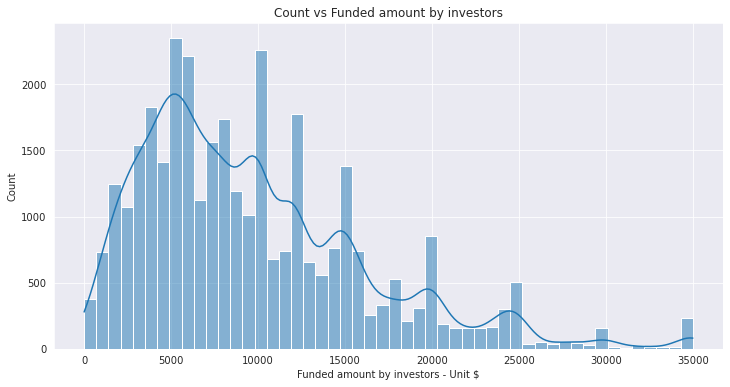

In [452]:
plt.figure(figsize=(12, 6))
plot_annual_inc = sns.histplot(data=loan_ds_6, x='funded_amnt_inv', kde=True, bins=50)
plt.xlabel('Funded amount by investors - Unit $')
plt.ylabel('Count')
plt.title('Count vs Funded amount by investors')
plt.show()

### Insights:

1. Count of loan is maximum for 5K and 10K amount invested by investors.
2. As the amount of fund increases count of loan decreases.
3. We can see spike at 5K, 10K, 15K, 20k, 25K. i.e. Maximum fund amount approved by investors are in multiples of 5K.

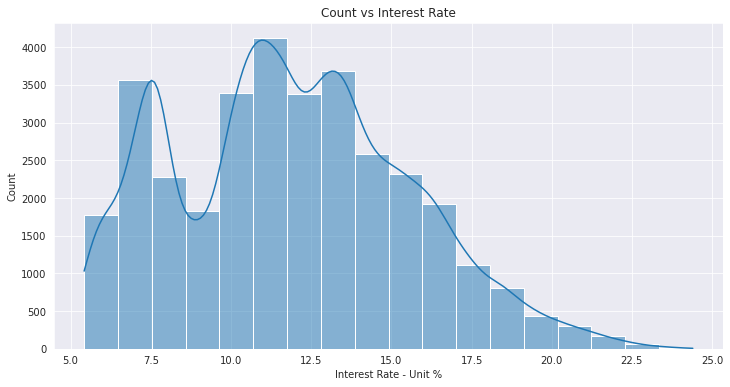

In [453]:
plt.figure(figsize=(12, 6))
plot_annual_inc = sns.histplot(data=loan_ds_6, x='int_rate', kde=True, bins=18)
plt.xlabel('Interest Rate - Unit %')
plt.ylabel('Count')
plt.title('Count vs Interest Rate')
plt.show()

### Insights:

1. Two mountain peak, one is around ~7 and another is arround ~12.
2. People are intrested in loan for interest rate around 7 and 12.
3. Count of loan continuously decreasing after ~13.

### Segmented Univariate Analysis
we will segment the categorical variables and then conduct univariate analysis across its categories

1. laon_status and annual_inc
2. loan_status and dti
3. loan_status and loan_amnt
4. loan_status and funded_amnt_inv
4. loan_status and int_rate

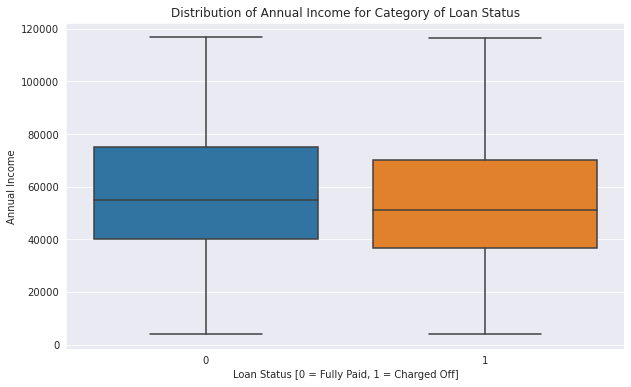

In [454]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='annual_inc', data=loan_ds_6)
plt.xlabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.ylabel('Annual Income')
plt.title('Distribution of Annual Income for Category of Loan Status')
plt.show()

In [455]:
loan_ds_6[loan_ds_6.loan_status == 0].annual_inc.mean()

58407.68457341201

In [456]:
loan_ds_6[loan_ds_6.loan_status == 1].annual_inc.mean()

54252.77512954408

### Insights:

Annual income of defaulters is relatively lesser than the annual income of fully paid borrowers. mean of anuual income is relatively heigher for fully paid.

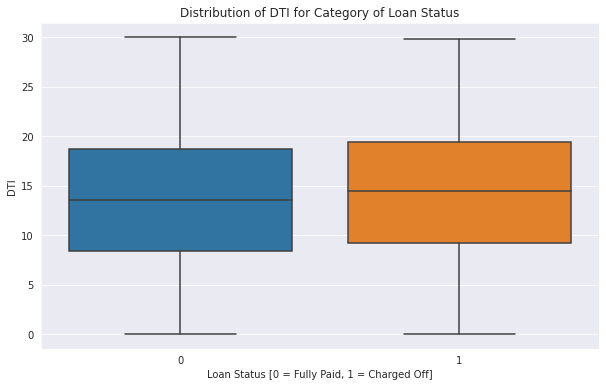

In [457]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='dti', data=loan_ds_6)
plt.xlabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.ylabel('DTI')
plt.title('Distribution of DTI for Category of Loan Status')
plt.show()

### Insights:

Debt to income ratio is relatively heigher for defaulters. 75th and 50th quantile of dti is relatively heigher for defaulters.

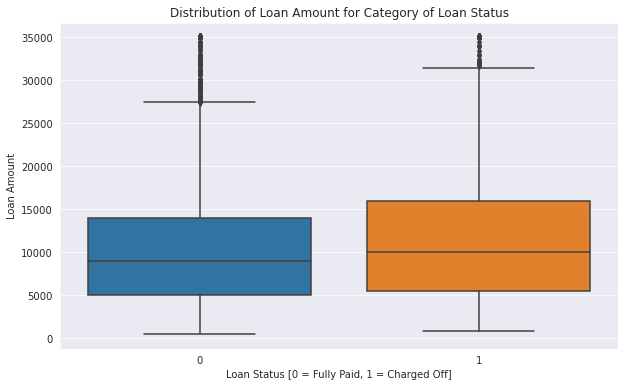

In [458]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_amnt', data=loan_ds_6)
plt.xlabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.ylabel('Loan Amount')
plt.title('Distribution of Loan Amount for Category of Loan Status')
plt.show()

### Insights:

Loan amount are relatively heigher for defaulters. 75th and 50th quantile of loan amount is relatively heigher for defaulters.

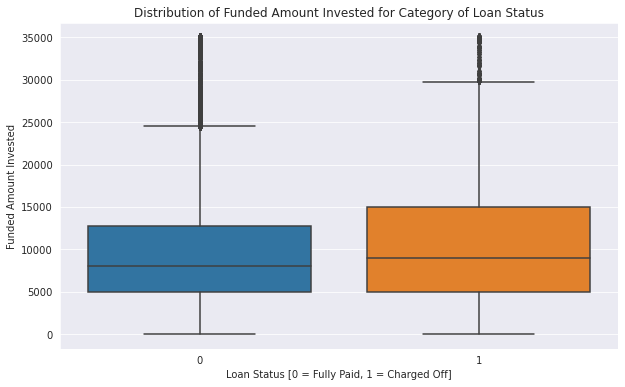

In [459]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='funded_amnt_inv', data=loan_ds_6)
plt.xlabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.ylabel('Funded Amount Invested')
plt.title('Distribution of Funded Amount Invested for Category of Loan Status')
plt.show()

### Insights:

Amount invested by investors is relatively heigher for defaulters. 75th and 50th quantile of funded amount by investors is relatively heigher for defaulters.

### Bivariate Analysis

#### Correlation Matrix for entire dataset

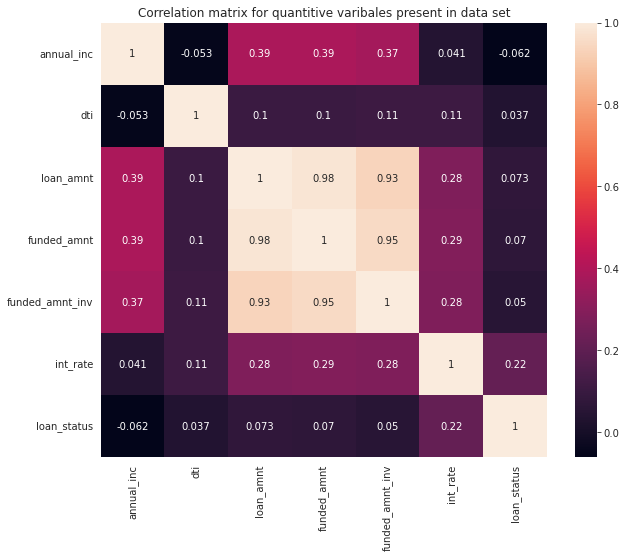

In [460]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=loan_ds_6.corr(), annot=True)
plt.title('Correlation matrix for quantitive varibales present in data set')
plt.show()

### Insights:
1. Loan status is negatively correlated with annual income with correlation value equals to -0.062. Degree of correlation is almost zero.
2. Loan status is positively correlated with dti, loan amount funden amount and interest rate with correlation values between 0.037 to 0.22. Degree of correlation is almost zero.
3. Loan amount is positively correlated with funded amount and funded amount by investors with correlation value of 0.98 and 0.93. Degree of correlation is high.

### Loan Status vs DTI

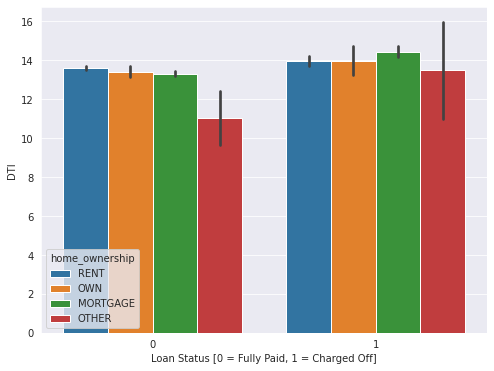

In [461]:
plt.figure(figsize=(8, 6))
sns.barplot(data=loan_ds_6, x='loan_status', y='dti', hue='home_ownership')
plt.xlabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.ylabel('DTI')
plt.show()

### Insights:

1. DTI for defaulters are greater for all kind of category in home ownership.
2. DTI for OTHER category in home ownership has a bigger difference.

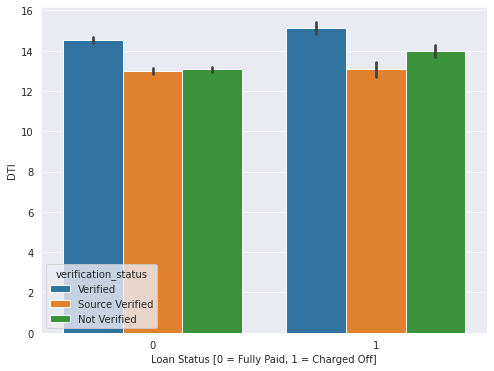

In [462]:
plt.figure(figsize=(8, 6))
sns.barplot(data=loan_ds_6, x='loan_status', y='dti', hue='verification_status')
plt.xlabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.ylabel('DTI')
plt.show()

### Insights:

DTI for defaulters are greater for all kind of category in verification status except source verified.

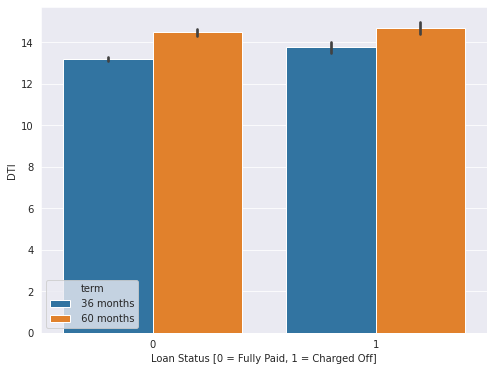

In [463]:
plt.figure(figsize=(8, 6))
sns.barplot(data=loan_ds_6, x='loan_status', y='dti', hue='term')
plt.xlabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.ylabel('DTI')
plt.show()

### Insights:

DTI for defaultors is slightly higher in all category of term 

<Figure size 720x432 with 0 Axes>

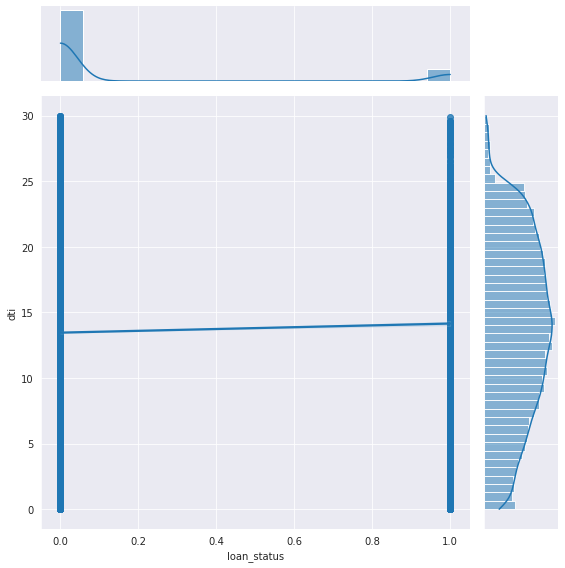

In [464]:
plt.figure(figsize=(10, 6))
sns.jointplot(data=loan_ds_6, x='loan_status', y='dti', kind='reg', height=8)
plt.xlabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.ylabel('DTI')
plt.show()

### Insights:

0 = Fully Paid borrowers
1 = Charged Off borrowers (defaulters)

=> DTI ratio is slightly more for defaulters.

### Loan Status vs Annual Income

<Figure size 720x432 with 0 Axes>

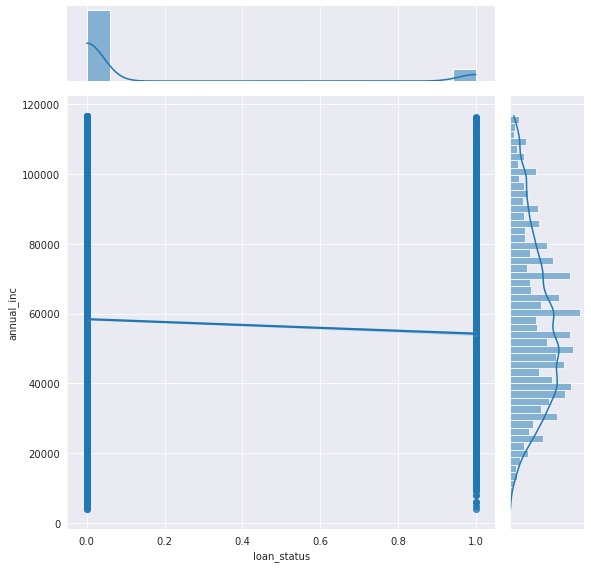

In [465]:
plt.figure(figsize=(10, 6))
sns.jointplot(data=loan_ds_6, x='loan_status', y='annual_inc', kind='reg', height=8)
plt.xlabel('Loan Status  [0 = Fully Paid, 1 = Charged Off]')
plt.ylabel('Annual Income')
plt.show()

### Insights:

Annual income of defaulters are slightly lesser compare to fully paid borrowers.

### Loan Status vs Interest Rate

<Figure size 720x432 with 0 Axes>

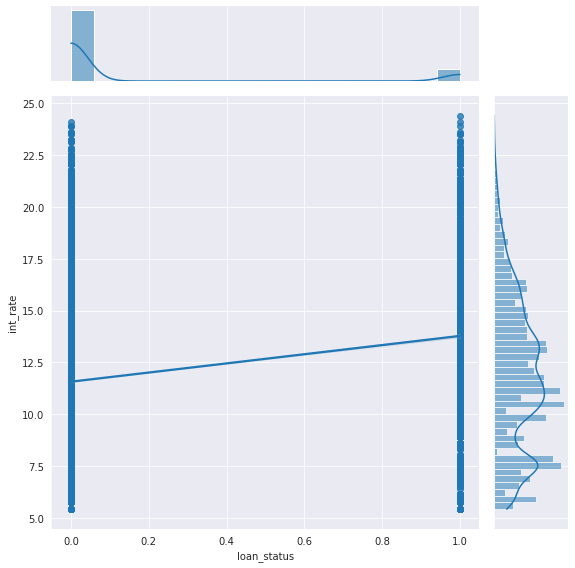

In [466]:
plt.figure(figsize=(10, 6))
sns.jointplot(data=loan_ds_6, x='loan_status', y='int_rate', kind='reg', height=8)
plt.xlabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.ylabel('Interest Rate')
plt.show()

### Insights:

Interest rates for defaulters is slightly higher compare to fully paid borrowers.

### Loan amount vs Funded amount

<Figure size 720x432 with 0 Axes>

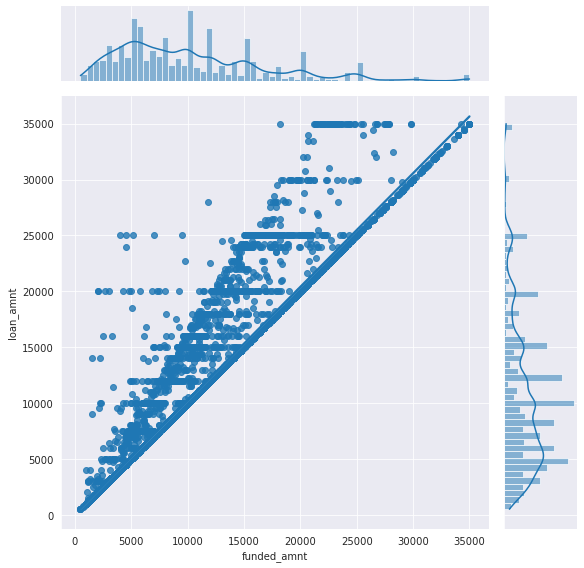

In [467]:
plt.figure(figsize=(10, 6))
sns.jointplot(data=loan_ds_6, x='funded_amnt', y='loan_amnt', kind='reg', height=8)
plt.xlabel('Loan Amount')
plt.ylabel('Funded Amount')
plt.show()

### Insights:

1. Funded amount is always lesser or equal to loan amount.
2. Loan of higher amount are less likely to be funded.

### Loan Amount vs Funded amount by investors

<Figure size 720x432 with 0 Axes>

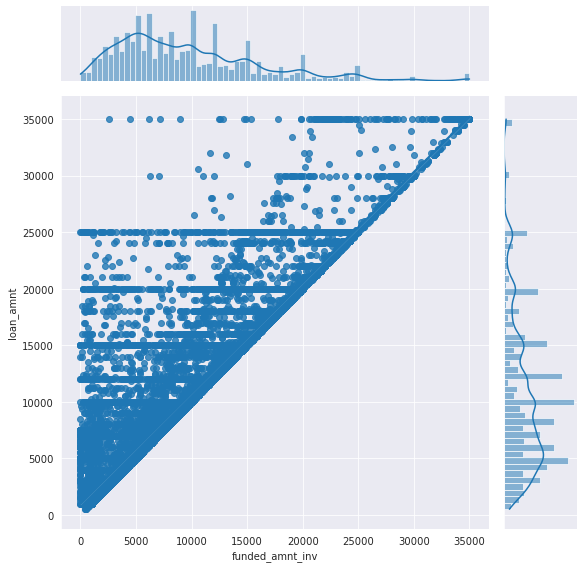

In [468]:
plt.figure(figsize=(10, 6))
sns.jointplot(data=loan_ds_6, x='funded_amnt_inv', y='loan_amnt', kind='reg', height=8)
plt.xlabel('Loan Amount')
plt.ylabel('Funded Amount Investors')
plt.show()

### Insights:

1. Funded amount by investors is always lesser or equal to loan amount.
2. Loan of higher amount are less likely to be funded by investors.
3. In some cases, difference between loan amount and funded amount by investor is very high.

### Funded Amount vs Funded amount by investors

<Figure size 720x432 with 0 Axes>

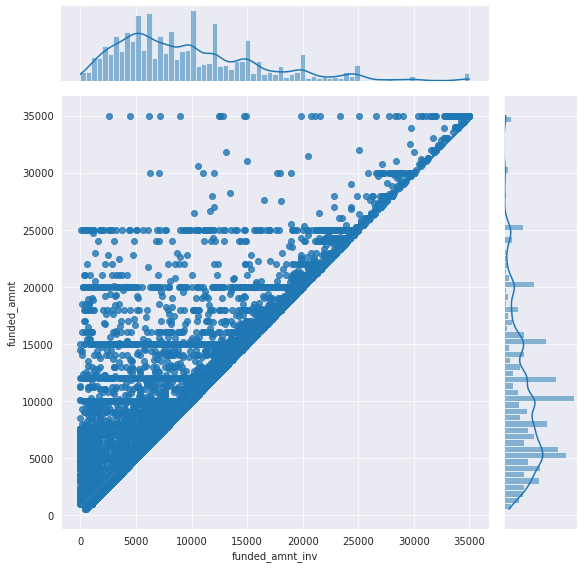

In [469]:
plt.figure(figsize=(10, 6))
sns.jointplot(data=loan_ds_6, x='funded_amnt_inv', y='funded_amnt', kind='reg', height=8)
plt.xlabel('Funded Amount')
plt.ylabel('Funded Amount Investors')
plt.show()

### Insights:

1. Funded amount by investors is always lesser or equal to Funded amount by company.
2. In some cases, difference between Funded amount by company and funded amount by investor is very high.

### Loan Status vs Home Ownership

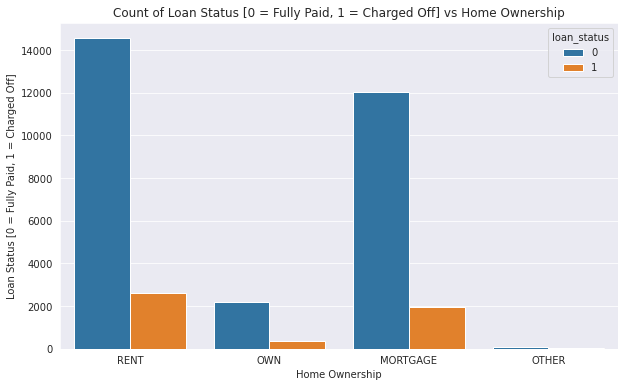

In [470]:
plt.figure(figsize=(10, 6))
sns.countplot(data=loan_ds_6, x='home_ownership', hue='loan_status')
plt.xlabel('Home Ownership')
plt.ylabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.title('Count of Loan Status [0 = Fully Paid, 1 = Charged Off] vs Home Ownership')
plt.show()

### Insights:

1. Most defaulter belongs to RENT or MORTGAGE category of home ownership.

### Loan Status vs Verification Status

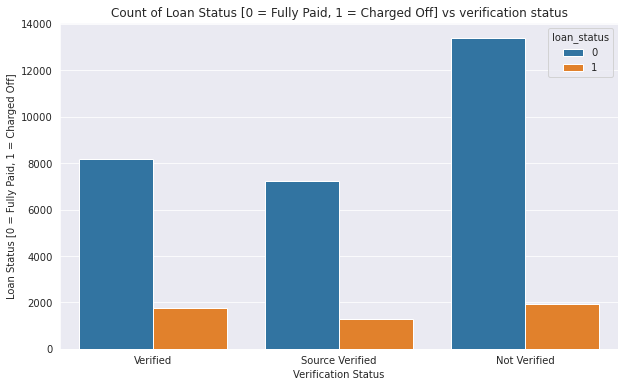

In [471]:
plt.figure(figsize=(10, 6))
sns.countplot(data=loan_ds_6, x='verification_status', hue='loan_status')
plt.xlabel('Verification Status')
plt.ylabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.title('Count of Loan Status [0 = Fully Paid, 1 = Charged Off] vs verification status')
plt.show()

### Insights:

1. Number of not verified loan is very huge.
2. Many non verified loans have fully paid. 

**Question**: When the company thinks they can give loan without verification? Are these loans belongs to lower amount?

### Loan Status vs Purpose

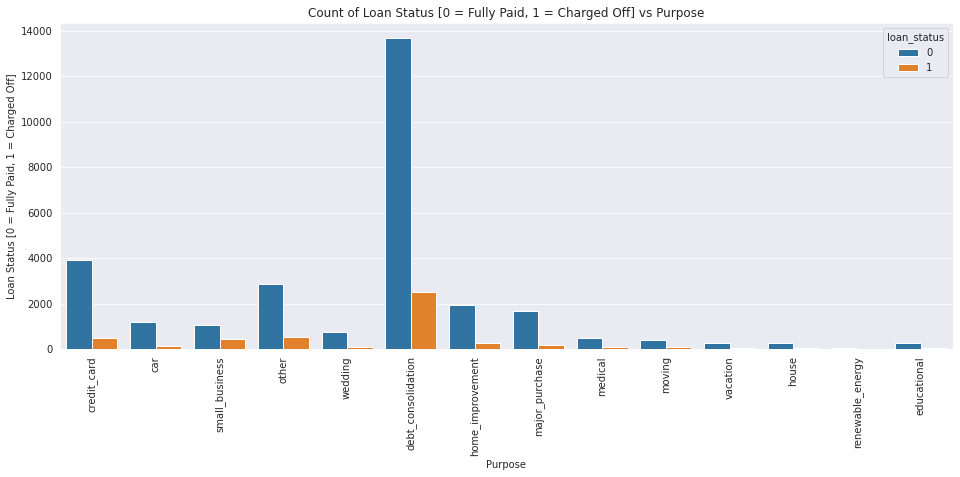

In [472]:
plt.figure(figsize=(16, 6))
sns.countplot(data=loan_ds_6, x='purpose', hue='loan_status')
plt.xlabel('Purpose')
plt.xticks(rotation=90)
plt.ylabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.title('Count of Loan Status [0 = Fully Paid, 1 = Charged Off] vs Purpose')
plt.show()

### Insights:

Number of defaulter are more than 2000 for debt consolidation purpose.

### Loan Status vs Employment Length

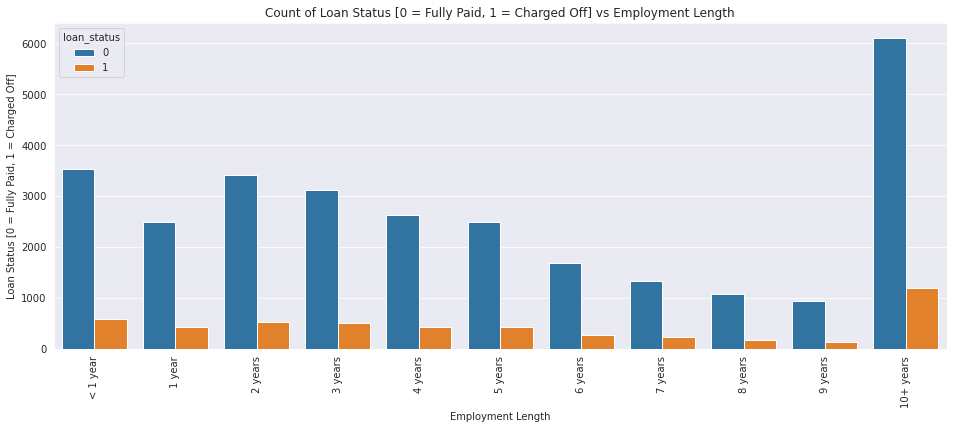

In [478]:
plt.figure(figsize=(16, 6))
sns.countplot(data=loan_ds_6, x='emp_length', hue='loan_status', order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'])
plt.xlabel('Employment Length')
plt.xticks(rotation=90)
plt.ylabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.title('Count of Loan Status [0 = Fully Paid, 1 = Charged Off] vs Employment Length')
plt.show()

### Insights:

More than 1000 defaulters are having employment length greater than 10+ years.

### Loan Status vs Terms

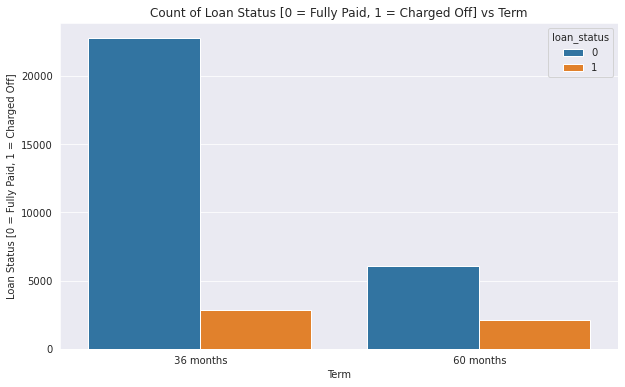

In [474]:
plt.figure(figsize=(10, 6))
sns.countplot(data=loan_ds_6, x='term', hue='loan_status')
plt.xlabel('Term')
plt.ylabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.title('Count of Loan Status [0 = Fully Paid, 1 = Charged Off] vs Term')
plt.show()

### Insights:

Short term loans having more defaulters.

### Loan Status vs Grades

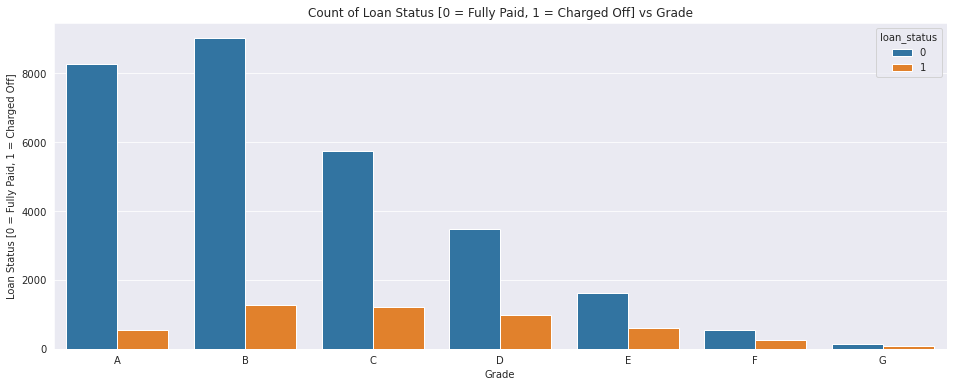

In [479]:
plt.figure(figsize=(16, 6))
sns.countplot(data=loan_ds_6, x='grade', hue='loan_status', order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.xlabel('Grade')
plt.ylabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.title('Count of Loan Status [0 = Fully Paid, 1 = Charged Off] vs Grade')
plt.show()

### Insights:

1. Ratio of defaulters after grade B is quite heigher. 
2. Tendency of defaulters are more from group C to G.

### Loan Status vs Address State

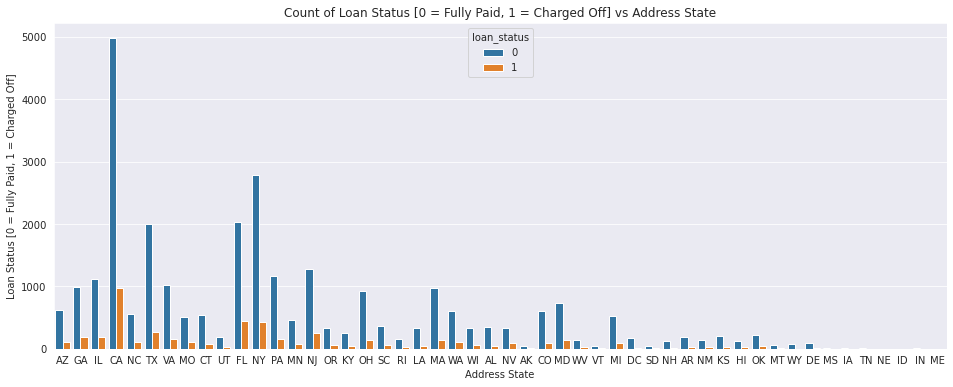

In [477]:
plt.figure(figsize=(16, 6))
sns.countplot(data=loan_ds_6, x='addr_state', hue='loan_status')
plt.xlabel('Address State')
plt.ylabel('Loan Status [0 = Fully Paid, 1 = Charged Off]')
plt.title('Count of Loan Status [0 = Fully Paid, 1 = Charged Off] vs Address State')
plt.show()

### Insights:

There are more defaulters belongs to state CA, TX, FL, NY anf NJ.

## Recommendations

1. More than 4.5K defaulters are from MORTGAGE and RENT category of home ownership. It will be great to check the DTI and purpose for these categories before approval.
2. More than 16K loans are not verified. It will be benifial to the comapny if they can reduce the number by strenthening the verification process.
3. People are taking loan mostly for debt consolidation (one of the category in pupose). The number is more than ~17K out of ~37K. This is a huge number. Company should think of their business approch. The number of loan for other purpose e.g. house, renewable energy and education is very low.
4. More than ~1K borrowers become defaulters out of ~7K borrowers for 10+ years category of employment length. The ratio is 1 out of 7. It will be great to check the DTI and purpose for those application before approval.
5. Approximately 13K loans belongs to category of less than year or more than 10 years. Please do proper verification before approval.
6. There are more defaulters belongs to state CA, TX, FL, NY anf NJ as there are more loans from these state. Please do strenthen the process of verification in these states.
7. DTI ratio should not be more than 13.5 to avoid defaulters.
8. Average annual income should be greater than 58K (USD) to avoid defaulters.